## 02 - Sampling the Imaginary

#### Imports

In [1]:
# ruff: noqa: F405
from init_notebook import *

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-01-27T19:51:15.472017+04:00

Python implementation: CPython
Python version       : 3.13.1
IPython version      : 8.31.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

xarray     : 2025.1.1
arviz      : 0.20.0
pymc       : 5.20.0
statsmodels: 0.14.4
scipy      : 1.15.1
pandas     : 2.2.3
watermark  : 2.5.0
numpy      : 1.26.4
matplotlib : 3.10.0



#### Introduction

Suppose there is a blood test that correctly detects vampirism 95% of the time. In more precise and mathematical notation, $P(\text{positive test result}\mid\text{vampire})=0.95$. It’s a very accurate test, nearly always catching real vampires. It also make mistakes, though, in the form of **false positives**. One percent of the time, it incorrectly diagnoses normal people as vampires, $P(\text{positive test result}\mid\text{mortal})=0.01$. The final bit of information we are told is that vampires are rather rare, being only 0.1% of the population, implying $P(\text{vampire})=0.001$. Suppose now that someone tests positive for vampirism. What’s the probability that he or she is a bloodsucking immortal?

|                  | Vampire | Mortal  |
|------------------|---------|--------|
| Test Vampire     | 0.95    | 0.01   |
| Test Not Vampire | 0.05    | 0.99   |

$$P(\text{Vampire} \mid \text{Positive}) = \frac{P(\text{Positive} \mid \text{Vampire})P(\text{Vampire})}{P(\text{Positive})}$$

- $P(\text{Vampire}) = 0.001$
- $P(\text{Positive} \mid \text{Vampire}) = 0.95$
- $P(\text{Positive}) = P(\text{Positive} \mid \text{Vampire})P(\text{Vampire}) + P(\text{Positive} \mid \text{Mortal})P(\text{Mortal})$
- $P(\text{Positive} \mid \text{Morta}) = 0.01$ (False Positive)
- $P(\text{Positive}) = (0.95)(0.001) + (0.01)(0.999)$

That corresponds to an 8.7% chance that the suspect is actually a vampire.

In [4]:
pr_positive_vampire = 0.95
pr_positive_mortal = 0.01
pr_vampire = 0.001
pr_positive = pr_positive_vampire * pr_vampire + \
              pr_positive_mortal * (1 - pr_vampire)

pr_vampire_positive = pr_positive_vampire * pr_vampire / pr_positive

print(f'P(Vampire | Positive) = {pr_vampire_positive:.2%}')

P(Vampire | Positive) = 8.68%


Most people find this result counterintuitive. And it’s a very important result, because it mimics the structure of many realistic testing contexts, such as HIV and DNA testing, criminal profiling, and even statistical significance testing. Whenever the condition of interest is very rare, having a test that finds all the true cases is still no guarantee that a positive result carries much information at all. The reason is that **most positive results are false positives, even when all the true positives are detected correctly**.

Suppose that instead of reporting probabilities, as before, we are told the following:
1) In a population of 100,000 people, 100 of them are vampires.
2) Of the 100 who are vampires, 95 of them will test positive for vampirism.
3) Of the 99,900 mortals, 999 of them will test positive for vampirism.

If we test all 100,000 people, what proportion of those who test positive for vampirism actually are vampires? Now we can just count up the number of people who test positive: $95 +999 =1094$. Out of these 1094 positive tests, 95 of them are real vampires, so that implies:
$$P(\text{Vampire} \mid \text{Positive}) = \frac{95}{1094} \approx 0.087$$

It’s exactly the same answer as before, but without a seemingly arbitrary rule. The second presentation of the problem, using counts rather than probabilities, is often called the *frequency format* or *natural frequencies*. 

In this notebook we exploit the intuitive frequency format by taking the probability distributions and sampling from them to produce counts. The posterior distribution is a probability distribution. And like all probability distributions, we can imagine drawing samples from it. The sampled events in this case are parameter values. Most parameters have no exact empirical realization. The Bayesian formalism treats parameter distributions as relative plausibility, not as any physical random process. In any event, randomness is always a property of information, never of the real world. But inside the computer, parameters are just as empirical as the outcome of a coin flip or a die toss or an agricultural experiment. The posterior defines the expected frequency that different parameter values will appear, once we start plucking parameters out of it.

**Why statistics can’t save bad science**

The vampirism example has the same logical structure as many different **signal detection problems**: (1) There is some binary state that is hidden from us; (2) we observe an imperfect cue of the hidden state; (3) we (should) use Bayes’ theorem to logically deduce the impact of the cue on our uncertainty. 

Scientific inference is sometimes framed in similar terms: (1) An hypothesis is either true or false; (2) we get a statistical cue of the hypothesis’ falsity; (3) we (should) use Bayes’ theorem to logically deduce the impact of the cue on the status of the hypothesis. It’s the third step that is hardly ever done. But let’s consider a toy example. Suppose the probability of a positive finding, when an hypothesis is true, is $P(\text{sig}|\text{true})=0.95$. That’s the power of the test. Suppose that the probability of a positive finding, when an hypothesis is false, is $P(\text{sig}|\text{false})=0.05$. That’s the false-positive rate, like the 5% of conventional significance testing. Finally, we have to state the base rate at which hypotheses are true. Suppose for example that 1 in every 100 hypotheses turns out to be true. Then $P(\text{true})=0.01$. No one knows this value, but the history of science suggests it’s small.

Now compute the posterior:
$$P(\text{true} \mid \text{pos}) = \frac{P(\text{pos} \mid \text{true})P(\text{true})}{P(\text{pos})} = \frac{P(\text{pos} \mid \text{true})P(\text{true})}{P(\text{pos} \mid \text{true})P(\text{true}) + P(\text{pos} \mid \text{false})P(\text{false})}$$

Plug in the appropriate values, and the answer is approximately $P(\text{true}|\text{pos})=0.16$. So a positive finding corresponds to a 16% chance that the hypothesis is true. This is the same low base-rate phenomenon that applies in medical (and vampire) testing. You can shrink the false-positive rate to 1% and get this posterior probability up to 0.5, only as good as a coin flip. The most important thing to do is to improve the base rate, $P(\text{true})$, and that requires thinking, not testing.

In [8]:
pr_positive_true = 0.95 
pr_true = 0.01
pr_positive_false = 0.05
pr_positive = pr_positive_true * pr_true + pr_positive_false * (1 - pr_true)

pr_true_positive = (pr_positive_true * pr_true) / pr_positive

print(f'P(True | Positive) = {pr_true_positive:.2%}')

P(True | Positive) = 16.10%


Many are uncomfortable with integral calculus. Working with samples transforms a problem in calculus into a problem in data summary, into a frequency format problem. An integral in a typical Bayesian context is just the total probability in some interval. That can be a challenging calculus problem. But once you have samples from the probability distribution, it’s just a matter of counting values in the interval. An empirical attack on the posterior allows on to ask and answer more questions about the model, without relying upon a captive mathematician. For this reason, it is easier and more intuitive to work with samples from the posterior, than to work with probabilities and integrals directly.

Some of the most capable methods of computing the posterior produce nothing but samples. Many of these methods are variants of Markov chain Monte Carlo techniques.

#### Sampling from a Grid-Approximation Posterior

The below code computes the posterior for a model using grid approximation. Remember, the posterior here means the probability of $p$ conditional on the data.

In [41]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(1, grid_points)

def binom_post_grid_approx(prior_func, grid_points=5, k=6, n=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    k (int): Number of successes
                    n (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    likelihood (numpy.array): array of likelihood at each point in the grid
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(k, n, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, likelihood, posterior

In [43]:
p_grid, _, posterior = binom_post_grid_approx(uniform_prior, grid_points=1_000, k=6, n=9)

np.random.seed(3)
samples = np.random.choice(p_grid, size=10_000, replace=True, p=posterior)
samples

array([0.66366366, 0.72272272, 0.56156156, ..., 0.35135135, 0.82682683,
       0.6956957 ])

In [40]:
grid_points = 1_000
p_grid = np.linspace(0, 1, grid_points)
prob_p = np.repeat(1, grid_points)
prob_data = stats.binom.pmf(6, 9, p_grid)
posterior = prob_data * prob_p 
posterior /= np.sum(posterior)

np.random.seed(3)
samples = np.random.choice(p_grid, size=10_000, replace=True, p=posterior)
samples

array([0.66366366, 0.72272272, 0.56156156, ..., 0.35135135, 0.82682683,
       0.6956957 ])

Now we wish to draw 10,000 samples from this posterior. Imagine the posterior is a bucket full of parameter values, numbers such as 0.1, 0.7, 0.5, 1, etc. Within the bucket, each value exists in proportion to its posterior probability, such that values near the peak are much more common than those in the tails. We’re going to scoop out 10,000 values from the bucket. Provided the bucket is well mixed, the resulting samples will have the same proportions as the exact posterior density. Therefore the individual values of $p$ will appear in our samples in proportion to the posterior plausibility of each value.

The workhorse here is `np.random.choice`, which randomly pulls values from a vector. The vector in this case is `p_grid`, the grid of parameter values. The probability of each value is given by `posterior`, which we computed just above.

AttributeError: module 'matplotlib.pyplot' has no attribute 'spines'

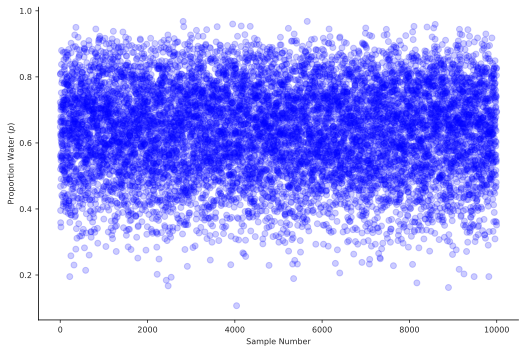

In [58]:
plt.plot(samples, 'bo', alpha=0.2)
plt.xlabel('Sample Number')
plt.ylabel('Proportion Water ($p$)')
plt.spines[['right', 'top']].set_visible(True);